### 01. Data Loading

In [1]:
# Data Loading
import pandas as pd
data = pd.read_csv('./data/000660.csv')

# Columns
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Rate']

# Date
Date = data['Date'].apply(lambda x : x.replace('년 ','-'))\
                   .apply(lambda x : x.replace('월 ','-'))\
                   .apply(lambda x : x.replace('일',''))
data['Date'] = Date

# Close
import numpy as np
Close = data['Close'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Close'] = Close

# Open
Open = data['Open'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Open'] = Open

# High
High = data['High'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['High'] = High

# Low
Low = data['Low'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Low'] = Low

# Rate
Rate = data['Rate'].apply(lambda x : x.replace('%','')).apply(lambda x : np.float(x))
data['Rate'] = Rate

# Time Reverse
data = data[::-1]

# Index
data = data.set_index('Date')

# Del Volume, Rate
del data['Volume']
del data['Rate']

# Data Head
data

,Close,Open,High,Low
Date,,,,
2011-08-23,17050.0,16200.0,17050.0,16000.0
2011-08-24,16250.0,17200.0,17550.0,15900.0
2011-08-25,17300.0,16900.0,17700.0,16700.0
2011-08-26,17950.0,17050.0,17950.0,16950.0
2011-08-29,19450.0,18550.0,19600.0,18350.0
...,...,...,...,...
2020-02-13,102000.0,100500.0,103500.0,100500.0
2020-02-14,104500.0,101500.0,105000.0,101000.0
2020-02-16,104500.0,104500.0,104500.0,104500.0


### 02. Rate

In [2]:
# List
columns = ["Close", "Open", "High", "Low"]

# Data Shift
for col in columns : 
    for s in range(1,2):
        data['{}_Shift_{}'.format(col,s)] = data[col].shift(s)
        
# NaN Omit
data = data.dropna()

# Rate
import warnings
warnings.filterwarnings(action='ignore') 
data['Close_Rate'] = 100 * (data['Close'] - data['Close_Shift_1']) / data['Close_Shift_1']
data['Open_Rate'] = 100 * (data['Open'] - data['Open_Shift_1']) / data['Open_Shift_1']
data['High_Rate'] = 100 * (data['High'] - data['High_Shift_1']) / data['High_Shift_1']
data['Low_Rate'] = 100 * (data['Low'] - data['Low_Shift_1']) / data['Low_Shift_1']

# Feature Selecting
data = data[['Close', 'Close_Rate', 'Open_Rate', 'High_Rate', 'Low_Rate']]

# Label
data['Close_SHIFT_1'] = data['Close'].shift(-1)
data['Rate'] = data['Close_SHIFT_1'] - data['Close']
data['Label'] = data['Rate'].apply(lambda x : 1 if x > 0 else 0)
data = data[['Close_Rate', 'Open_Rate', 'High_Rate', 'Low_Rate', 'Label']]

# Data Head
data

,Close_Rate,Open_Rate,High_Rate,Low_Rate,Label
Date,,,,,
2011-08-24,-4.692082,6.172840,2.932551,-0.625000,1
2011-08-25,6.461538,-1.744186,0.854701,5.031447,1
2011-08-26,3.757225,0.887574,1.412429,1.497006,1
2011-08-29,8.356546,8.797654,9.192201,8.259587,0
2011-08-30,-2.313625,7.277628,3.316327,3.542234,1
...,...,...,...,...,...
2020-02-13,2.000000,0.000000,2.475248,1.412714,1
2020-02-14,2.450980,0.995025,1.449275,0.497512,0
2020-02-16,0.000000,2.955665,-0.476190,3.465347,1


### 03. Train Test Split

In [3]:
train = data[:'2018-01-01']
valid = data['2018-01-01':'2019-01-01']
test = data['2019-01-01':]

### 04. Target / Input

In [4]:
X_train = train[['Close_Rate', 'Open_Rate', 'High_Rate', 'Low_Rate']]
X_valid = valid[['Close_Rate', 'Open_Rate', 'High_Rate', 'Low_Rate']]
X_test = test[['Close_Rate', 'Open_Rate', 'High_Rate', 'Low_Rate']]
Y_train = train[['Label']]
Y_valid = valid[['Label']]
Y_test = test[['Label']]

### 04. Data Normalization

In [5]:
# Train
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Valid
X_valid -= mean
X_valid /= std

# Test
X_test -= mean
X_test /= std

### 05. DNN

In [6]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics

# Model Build
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(4,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Model Compile
model.compile(optimizer = optimizers.RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# History
history = model.fit(X_train,
                    Y_train,
                    epochs = 20,
                    batch_size = 1000,
                    validation_data = (X_valid, Y_valid))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1784 samples, validate on 297 samples
Epoch 1/20
1784/1784 [==============================] - 3s 2ms/step - loss: 0.6890 - acc: 0.5471 - val_loss: 0.6769 - val_acc: 0.5926
Epoch 2/20
1784/1784 [==============================] - 0s 8us/step - loss: 0.6856 - acc: 0.5639 - val_loss: 0.6769 - val_acc: 0.5960
Epoch 3/20
1784/1784 [==============================] - 0s 8us/step - loss: 0.6848 - acc: 0.5639 - val_loss: 0.6762 - val_acc: 0.5892
Epoch 4/20
1784/1784 [==============================] - 0s 7us/step - loss: 0.6835 - acc: 0.5617 - val_loss: 0.6755 - val_acc: 0.5892
Epoch 5/20
1784/1784 [==============================] - 0s 9us/step - loss: 0.6826 - acc: 0.5633 - val_loss: 0.6756 - val_acc: 0.5892
Epoch 6/20
1784/1784 [==============================] - 0s 9us/step - loss: 0.6819 - acc: 0.5650 - val_loss: 0.6754 - val_acc: 0.5892
Epoch 7/20
1784/1784 [===========================

### Train Valid Loss Graph

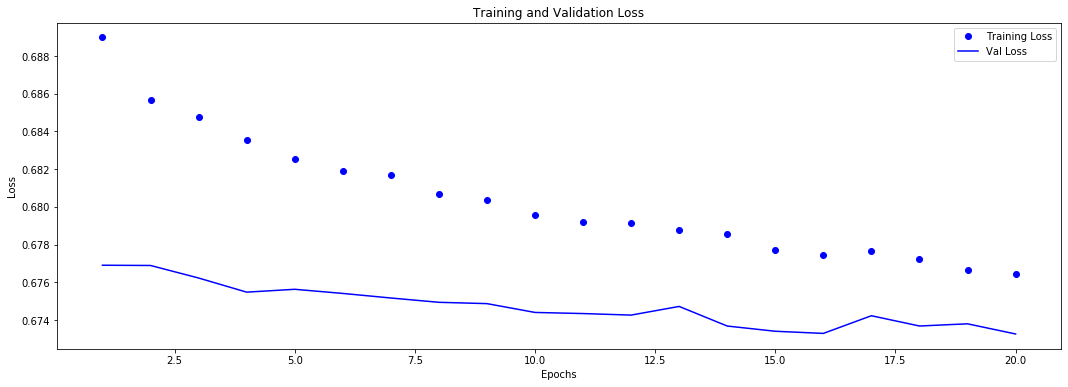

In [7]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(18,6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train Valid Accuracy

<Figure size 432x288 with 0 Axes>

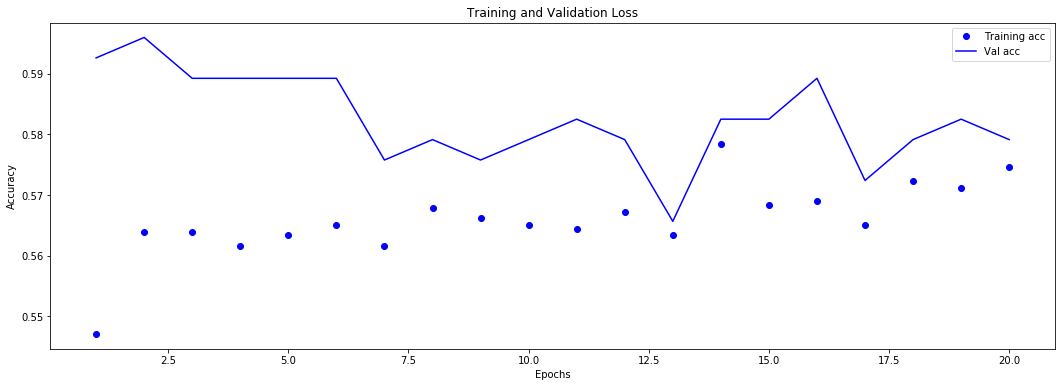

In [8]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.figure(figsize=(18,6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Val acc')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###  Test Result

In [20]:
results = model.evaluate(X_test, Y_test)
print('|  Test  |  Loss = {:.4f}  |  Accuracy = {:.2f}%  |' .format(results[0], 100*results[1]))

316/316 [==============================] - 0s 66us/step
|  Test  |  Loss = 0.6861  |  Accuracy = 55.06%  |
